In [ ]:
## This is Feedforward Neural Net model for MNIST
# It includes the following modules:
#   - Pre-process dataset
#   - Elaborate Neural networks recipes 
#   - Define training procedures
#   - Train and test models
#   - Generate prediction on new data
#   - Observe metrics

# Import main libaries

In [1]:
from __future__ import print_function

import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd

Using TensorFlow backend.


# load and preprocess data

In [2]:
def preprocessDataset():
    ## load the train data, type is pd.dataframe, shape is (42000,785)
    train = pd.read_csv('train.csv')
    
    ## load the test data, type is pd.dataframe, shape is (28000,784)
    test = pd.read_csv('test.csv')
    
    ## Separate the features X_train (42000,884) and the object labels y_train (42000,)
    X_train = train.drop('label', 1)
    y_train = train['label']
    
    ## Prepare the testing features X_test (28000,784)
    X_test = test
    
    ## Transform objects to one-hot
    ## i.e., from '6' to [0,0,0,0,0,0,1,0,0,0]
    ## y_train type now is numpy.ndarray
    y_train = np_utils.to_categorical(y_train, 10)
    
    ## Set features' numeric types
    X_train=X_train.astype('float32')
    X_test=X_test.astype('float32')
    
    ## Normalization features
    ## option 1: Min-Max Normalize value to [0, 1]
    X_train /= 255
    X_test /= 255
    
    #################################################################
    # option 2: proceed w/ standardizing datasets by z-scoring (de-mean, uni-variance).
    # X_train = preprocessing.scale(X_train)
    # X_test = preprocessing.scale(X_test)
    #################################################################
    
    ## Transform datatype from pd.dataframe to numpy.ndarray as
    ## kera model.fit only accept numpy.ndarray
    X_train=X_train.as_matrix()
    X_test=X_test.as_matrix()
    
    return X_train,y_train,X_test

In [3]:
X_train,y_train,X_test = preprocessDataset()

In [4]:
## Show part of training data: features and labels
## Each row is a sample, and each column represents a feature.
print("{:^43}".format("X"), "|", "{:^4}".format("y"))
print("="*50)
for sample_id in range(10):
    print("{:.2f} {:.2f} ... {:.2f} {:.2f} {:.2f} ...  {:.2f} {:.2f}".format(
            X_train[sample_id][0], X_train[sample_id][1],
            X_train[sample_id][156], X_train[sample_id][157], X_train[sample_id][158],
            X_train[sample_id][-2], X_train[sample_id][-1]), "| ",
           "{:.0f}".format(y_train[sample_id][0]))

                     X                      |  y  
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.96 0.59 0.13 ...  0.00 0.00 |  1
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.04 0.30 ...  0.00 0.00 |  0
0.00 0.00 ... 0.99 0.99 0.45 ...  0.00 0.00 |  1
0.00 0.00 ... 0.98 0.96 0.28 ...  0.00 0.00 |  1
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.70 1.00 1.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.99 0.49 0.00 ...  0.00 0.00 |  0


# Define NN model

In [8]:
def defineModel():
    ## Define network structures (i.e.: only one layer, or multi-layers with different width)
    first_layer_width = 128
    second_layer_width = 64
    
    ## Define activation function (i.e.:'sigmoid','tanh','relu')
    activation_func = 'relu' 
    
    ## Define loss function (i.e.:'mean_squared_error', 'categorical_crossentropy')
    loss_function = 'categorical_crossentropy'
    
    ## Define dropout rate (i.e.: 0.0, 0.5, 0.9)
    dropout_rate = 0.0
    
    ## Define Regularization (i.e.: None, l1(0.01), l2(0.01))
    weight_regularizer = None
    
    ## Define learning rate (i.e.: 0.5, 0.1, 0.01, 0.001)
    learning_rate = 0.1
    
    ## Initialize model,the type of model is keras.models.Sequential
    model = Sequential()
    
    ## First hidden layer with 'first_layer_width' neurons. 
    ## Also need to specify input dimension.
    ## 'Dense' means fully-connected.
    model.add(Dense(first_layer_width, input_dim=784, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    ## Second hidden layer.
    if second_layer_width > 0:
        model.add(Dense(second_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate)) 
    
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(10))
    ## For classification, the activation is softmax
    model.add(Activation('softmax'))
    
    ## Define optimizer (i.e.: SGD, RMSprop())
    opt = SGD(lr=learning_rate, clipnorm=5.)
    
    ## Define loss function = 'categorical_crossentropy' or 'mean_squared_error'
    model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

    return model

# Define training produre

In [9]:
def trainModel(data=None, epochs=20):
    ## Define mini-batch size (i.e.: 128, 256, 512)
    mini_batch= 128
    
    ## Define start_time
    start_time = time.time()
    
    ## Define the model
    model = defineModel()
    
    ## Ask for data
    if data is None:
        print("Must provide data.")
        return
    X_train, X_test, y_train = data
    
    ## Train the model start...
    print('Start training...')
    
    ## Use the first 80% of samples to train, last 20% samples to validate
    ## Training proportion
    #split_proportion = 0.8
    split_proportion = 0.95
    
    ## Get the number of the training examples
    nbr_train = int(len(X_train) * split_proportion)
    
    
    ## Start the model training
    history = model.fit(X_train[:nbr_train], y_train[:nbr_train], nb_epoch=epochs, batch_size=mini_batch,
              validation_data=(X_train[nbr_train:], y_train[nbr_train:]))
    
    ## Get total training time
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history

# Start training

In [10]:
trained_model, training_history = trainModel(data=[X_train, X_test, y_train])

Start training...
Train on 39900 samples, validate on 2100 samples
Epoch 1/20
39900/39900 [==============================] - 4s - loss: 0.5179 - acc: 0.8580 - val_loss: 0.2981 - val_acc: 0.9148
Epoch 2/20
39900/39900 [==============================] - 3s - loss: 0.2444 - acc: 0.9290 - val_loss: 0.2328 - val_acc: 0.9357
Epoch 3/20
39900/39900 [==============================] - 4s - loss: 0.1892 - acc: 0.9453 - val_loss: 0.2007 - val_acc: 0.9381
Epoch 4/20
39900/39900 [==============================] - 4s - loss: 0.1541 - acc: 0.9559 - val_loss: 0.1774 - val_acc: 0.9514
Epoch 5/20
39900/39900 [==============================] - 4s - loss: 0.1309 - acc: 0.9618 - val_loss: 0.1563 - val_acc: 0.9552
Epoch 6/20
39900/39900 [==============================] - 4s - loss: 0.1113 - acc: 0.9680 - val_loss: 0.1504 - val_acc: 0.9605
Epoch 7/20
39900/39900 [==============================] - 3s - loss: 0.0977 - acc: 0.9722 - val_loss: 0.1360 - val_acc: 0.9619
Epoch 8/20
39900/39900 [====================

# Define Plotting

In [11]:
def plotHistory(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    
    ## Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  

# Observe Training Process

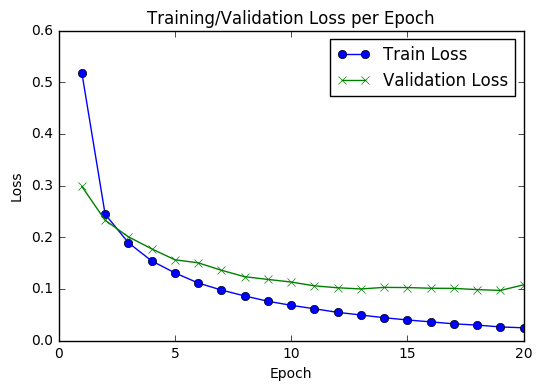

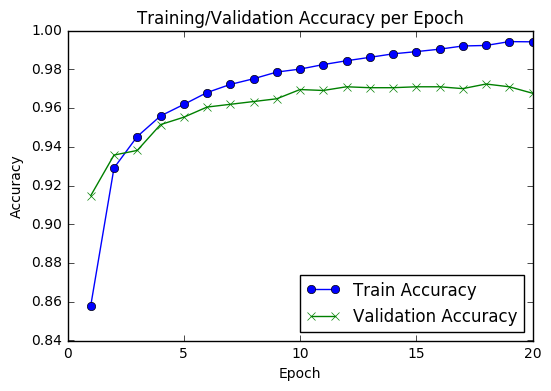

In [12]:
plotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
plotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

# Observe Regularization Effects

In [13]:
def drawWeightHistogram(x):
    ## the histogram of the data
    fig = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

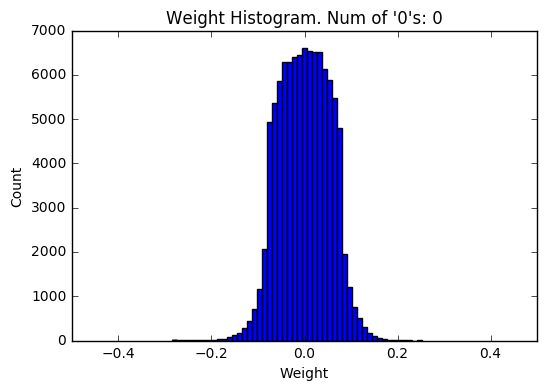

In [14]:
w1 = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(w1)

In [15]:
type(trained_model)

keras.models.Sequential

# Generate Prediction on New Data

In [70]:
def genPred(model=None, data=None, batch_size_number=0):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        return
    
    ## generate prediction
    # example: classes = model.predict_classes(X_test, batch_size=128)
    X_test = data
    
    # type(y_test) is numpy.ndarray, shape is (28000, )
    y_test = model.predict_classes(X_test, batch_size=batch_size_number)
    
    ## Transform objects to one-hot if needed
    ## i.e., from '6' to [0,0,0,0,0,0,1,0,0,0]
    ## y_test type is numpy.ndarray
    y_test_onehot = np_utils.to_categorical(y_test, 10)
    
    ## mesaure prediction probability
    proba = model.predict_proba(X_test, batch_size=batch_size_number)
    
    return y_test, y_test_onehot, proba

In [71]:
y_test, y_test_onehot, proba = genPred(model=trained_model, data=X_test, batch_size_number=128)

27904/28000 [============================>.] - ETA: 0s

In [72]:
y_test[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [73]:
y_test_onehot[0:10]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [38]:
proba[1]

array([  9.99999285e-01,   2.63978950e-10,   7.48083835e-07,
         4.34339564e-10,   1.88310766e-13,   1.09961720e-08,
         1.09582752e-08,   1.05985953e-09,   2.66482821e-12,
         1.77838633e-10], dtype=float32)

# Define Testing Procedure

In [39]:
## Using the testingModel function only if there is y_test existing;
## If not, just using genPred function to predict y_test
def testingModel(model=None, data=None):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        return
    X_test, y_test = data
    
    ## use model.evalute(x_test, y_test) to evaluate the performance
    scores = model.evaluate(X_test, y_test)
    return scores

# Test Trained Model

In [74]:
test_score = testingModel(model=trained_model, data=[X_test, y_test_onehot])
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

27872/28000 [============================>.] - ETA: 0sTest loss 0.0266, accuracy 100.00%


In [41]:
## customize showing input image figure
def showInputImage(data):
    """Visualize input image."""
    plot = plt.figure()
    plot.set_size_inches(2,2)
    plt.imshow(np.reshape(-data, (28,28)), cmap='Greys_r')
    plt.title("Input")
    plt.axis('off')
    plt.show()

In [42]:
## customize showing the hidden layer output
def showHiddenLayerOutput(input_data, target_layer_num):
    """Visualize output from the target hidden layer."""
    from keras import backend as K
    ## Backend converter: to TensorFlow
    target_layer = K.function(trained_model.inputs, [trained_model.layers[target_layer_num].output])
    ## Extract output from the target hidden layer.
    target_layer_out = target_layer([input_data])
    plot = plt.figure()
    plot.set_size_inches(2,2)
    plt.imshow(np.reshape(-target_layer_out[0][0], (16,-1)), cmap='Greys_r')
    plt.title("Hidden layer " + str(target_layer_num))
    plt.axis('off')
    plt.show()

In [43]:
## customize showing the final output figure
def showFinalOutput(input_data):
    """Calculate final prediction."""
    from keras import backend as K
    ## Backend converter: to TensorFlow
    ## Calculate final prediction.
    last_layer = K.function(trained_model.inputs, [trained_model.layers[-1].output])
    last_layer_out = last_layer([input_data])
    print("Final prediction: " + str(np.argmax(last_layer_out[0][0])) )


In [46]:
X_test[0].shape

(784,)

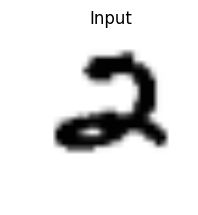

In [48]:
## showing the first row (first test data) in figure
showInputImage(X_test[0])

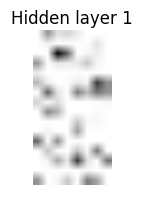

In [83]:
## showing the hidden layer output of the test data
showHiddenLayerOutput(X_test, 1)

In [50]:
## showing the final output of the test data based on the trained_model
showFinalOutput(X_test)

Final prediction: 2


In [75]:
y_test.shape

(28000,)

In [81]:
y_test[3]

9

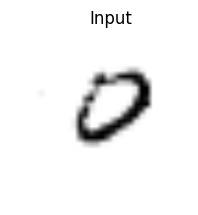

In [80]:
showInputImage(X_test[3])

# Submit the prediction results

In [68]:
def genSubmit(predictData):
    ## Create the file for submission if not exist
    # !touch dnn_submission_1.csv
    
    dnn_y_predict = predictData
    
    ## save to csv file with format
    dnn_submission = pd.DataFrame({'ImageId':range(1, 28001), 'Label': dnn_y_predict})
    dnn_submission.to_csv('dnn_submission_1.csv', index = False)

In [77]:
genSubmit(y_test)

# Check the submission result

In [79]:
## Check the first 5 data
!head -5 dnn_submission_1.csv

ImageId,Label
1,2
2,0
3,9
4,9
